In [17]:
import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [18]:
%load_ext autoreload
%autoreload 2

from rl_learning import SimplePolicy, MonetCarloSimulation, QTableDict, QLearningSimulation, EpsilonGreedyPolicy, Sarsa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Часть первая

## Простая стратегия

In [19]:
policy = SimplePolicy()
simulator = MonetCarloSimulation(gym.make("Blackjack-v0"), policy)

In [20]:
rewards = simulator.simulate(10_000)

100%|██████████| 10000/10000 [00:00<00:00, 10141.64it/s]


In [21]:
rows = []
for state, expected_reward in rewards.items():
    rows.append(state + (expected_reward,))

In [22]:
stat = pd.DataFrame(rows, columns=["player_sum", "dealer_open_card", "usable_ace", "reward"])

In [23]:
usable_ace_stat = stat[stat["usable_ace"] == True]
not_usable_ace_stat = stat[stat["usable_ace"] == False]

In [24]:
def plot_stat(data):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    player_axis_start = 2
    dealer_axis_start = 1
    player_sum = np.arange(player_axis_start, 21 + 1)
    dealer_show = np.arange(dealer_axis_start, 10 + 1)

    rewards_data = np.zeros((len(player_sum), len(dealer_show)), dtype=np.float32)
    rewards_data[data["player_sum"] - player_axis_start, data["dealer_open_card"] - dealer_axis_start] = data["reward"]

    x, y = np.meshgrid(player_sum, dealer_show, indexing="ij")

    ax.set_xlabel("Player sum")
    ax.set_ylabel("Dealer open card")
    ax.set_zlabel("Expected reward")

    ax.plot_wireframe(x, y, rewards_data)
    return fig

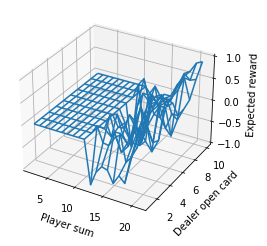

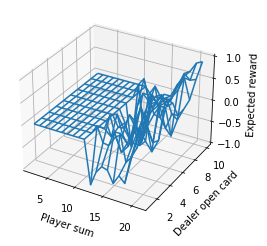

In [25]:
plot_stat(usable_ace_stat)

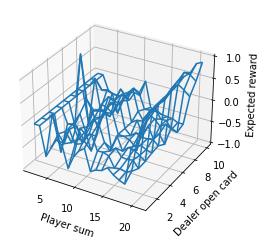

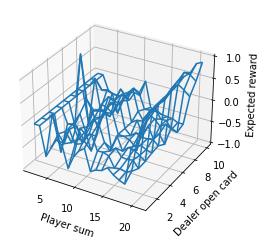

In [26]:
plot_stat(not_usable_ace_stat)

## Q-обучение

In [27]:
def generate_params_params(td_learning_cls, gammas, total_runs: int):
    values = []
    for gamma_param in gammas:
        q_function = QTableDict()
        gready_policy = EpsilonGreedyPolicy(q_function, 0.01)
        td_learning = td_learning_cls(gym.make("Blackjack-v0"), gready_policy, q_function, alpha=0.5, gamma=gamma_param)
        values.append((gamma_param,) + td_learning.simulate(total_runs))
    return values

In [28]:
gama = np.linspace(1e-1, 1, 20)
num_runs = 10_000

In [13]:
values = np.array(generate_params_params(QLearningSimulation, gama, num_runs))

100%|██████████| 10000/10000 [00:01<00:00, 9901.00it/s]


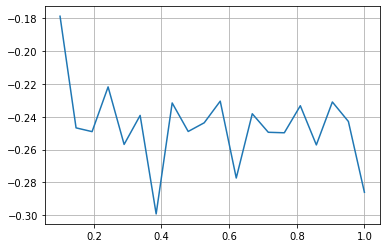

In [30]:
plt.plot(values[:, 0], values[:, 1])
plt.grid(True)

# Sarsa

In [31]:
values = np.array(generate_params_params(Sarsa, gama, num_runs))

100%|██████████| 10000/10000 [00:01<00:00, 6269.31it/s]


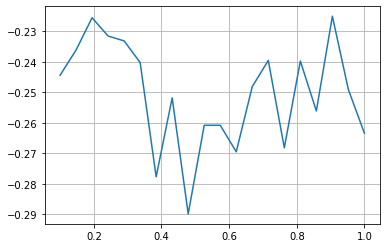

In [32]:
plt.plot(values[:, 0], values[:, 1])
plt.grid(True)